### Import libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
import numpy as np
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import random
import os
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from pytorch_tabular import TabularModel
from pytorch_tabular.models import TabNetModelConfig
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig
from pytorch_tabular.models import TabTransformerConfig



### Carico il dataset iniziale

In [2]:
filename = "dataset.csv"
df = pd.read_csv(filename)
print("Shape del dataframe: ", df.shape)
df = df.dropna()
df = df.drop_duplicates()
print("Shape del dataframe dopo rimozione valori null e ripetuti: ",df.shape)

X = df.drop(columns=['Year'])
y = df['Year']

os.makedirs('models', exist_ok=True)
os.makedirs('../Test_Module/models', exist_ok=True)

Shape del dataframe:  (252175, 91)
Shape del dataframe dopo rimozione valori null e ripetuti:  (252123, 91)


### Visualizzo i Dati

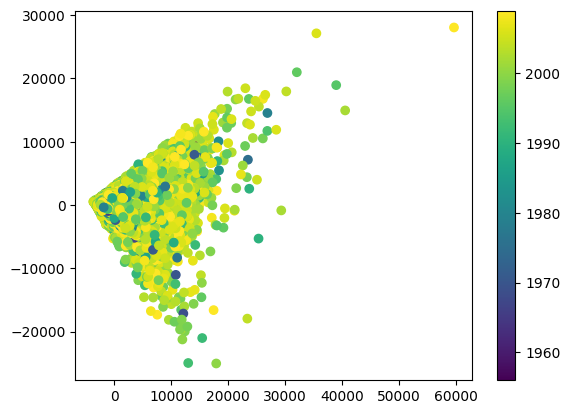

In [3]:
# VISUALIZZAZIONE IN 2 DIMENSIONI

pca = decomposition.PCA()
pca.fit(X)

X_p = pca.transform(X)
plt.scatter(X_p[:, 0], X_p[:, 1], c=y)
plt.colorbar()
plt.show()


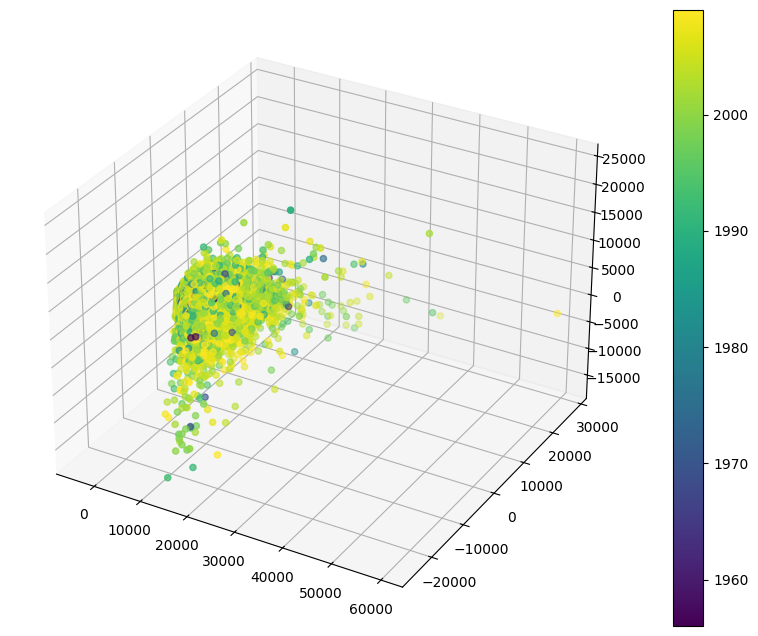

In [4]:
# VISUALIZZAZIONE IN 3 DIMENSIONI
pca = decomposition.PCA()
pca.fit(X)
X_p = pca.transform(X)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_p[:, 0], X_p[:, 1], X_p[:, 2], c=y)

cbar = fig.colorbar(scatter, ax=ax)  

plt.show()


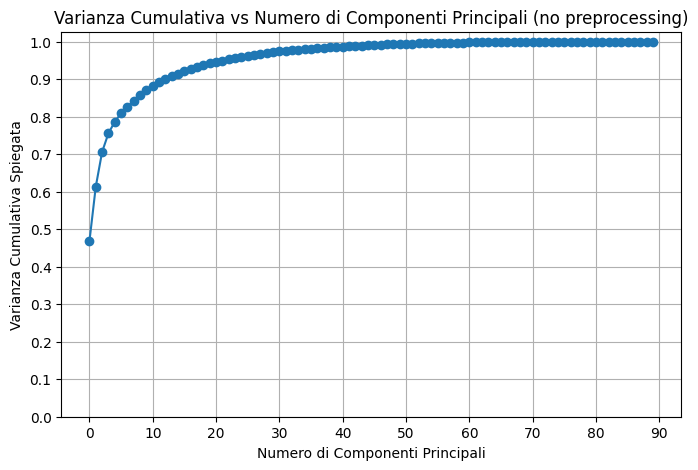

In [5]:
# VISUALIZZO LA VARIANZA CUMULATIVA PER NUMERO DI COMPONENTI PRINCIPALI (NO PREPROCESSING)

pca = decomposition.PCA()
X_train_view = pca.fit_transform(X)

varianza_cumulativa = np.cumsum(pca.explained_variance_ratio_)
#print(varianza_cumulativa)
#print(pca.explained_variance_ratio_)

plt.figure(figsize=(8,5))
plt.plot(varianza_cumulativa, marker='o')
plt.xticks(np.arange(0, 100, step=10)) 
plt.yticks(np.arange(0, 1.1, step=0.1)) 
plt.xlabel('Numero di Componenti Principali')
plt.ylabel('Varianza Cumulativa Spiegata')
plt.title('Varianza Cumulativa vs Numero di Componenti Principali (no preprocessing)')
plt.grid(True)
plt.show()

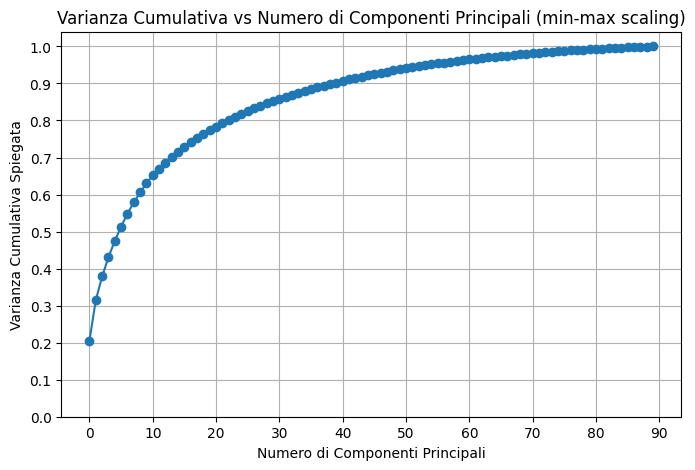

In [6]:
# VISUALIZZO LA VARIANZA CUMULATIVA PER NUMERO DI COMPONENTI PRINCIPALI (MIN-MAX SCALING)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

pca = decomposition.PCA()
X_train_view = pca.fit_transform(X_scaled)

varianza_cumulativa = np.cumsum(pca.explained_variance_ratio_)
#print(varianza_cumulativa)
#print(pca.explained_variance_ratio_)

plt.figure(figsize=(8,5))
plt.plot(varianza_cumulativa, marker='o')
plt.xticks(np.arange(0, 100, step=10)) 
plt.yticks(np.arange(0, 1.1, step=0.1)) 
plt.xlabel('Numero di Componenti Principali')
plt.ylabel('Varianza Cumulativa Spiegata')
plt.title('Varianza Cumulativa vs Numero di Componenti Principali (min-max scaling)')
plt.grid(True)
plt.show()

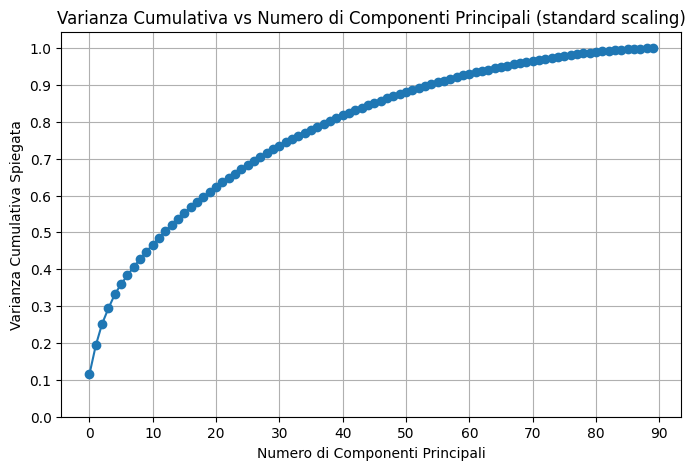

In [7]:
# VISUALIZZO LA VARIANZA CUMULATIVA PER NUMERO DI COMPONENTI PRINCIPALI (STANDARD SCALING)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = decomposition.PCA()
X_train_view = pca.fit_transform(X_scaled)

varianza_cumulativa = np.cumsum(pca.explained_variance_ratio_)
#print(varianza_cumulativa)
#print(pca.explained_variance_ratio_)

plt.figure(figsize=(8,5))
plt.plot(varianza_cumulativa, marker='o')
plt.xticks(np.arange(0, 100, step=10)) 
plt.yticks(np.arange(0, 1.1, step=0.1)) 
plt.xlabel('Numero di Componenti Principali')
plt.ylabel('Varianza Cumulativa Spiegata')
plt.title('Varianza Cumulativa vs Numero di Componenti Principali (standard scaling)')
plt.grid(True)
plt.show()

#### Identificazione Outliers (successivamente si è deciso di mantenerli per prestazioni migliori)

In [6]:
# Reset degli indici
df.reset_index(drop=True, inplace=True)

# Utilizzo dell'algoritmo KNN
knn = NearestNeighbors(n_neighbors=10)
knn.fit(df)

# Ottengo distanze e indici dei K-Neighbors più vicini
distances, indices = knn.kneighbors(df)

# Identifico gli outliers
distance_threshold = np.mean(distances) + 2 * np.std(distances)
outliers = np.where(np.mean(distances, axis=1) > distance_threshold)

# Punti identificati come anomalie
anomaly_points = df.iloc[outliers]

#print("Punti identificati come anomalie:\n", anomaly_points)

In [7]:
# Stampo la shape del dataframe con e senza outliers
df_clean = df.drop(index=outliers[0])
print(f'DF SHAPE WITH OUTLIERS: {df.shape}')
print(f'DF SHAPE WITHOUT OUTLIERS: {df_clean.shape}')

DF SHAPE WITH OUTLIERS: (252123, 91)
DF SHAPE WITHOUT OUTLIERS: (245019, 91)


##### Visualizzo i dati senza outliers

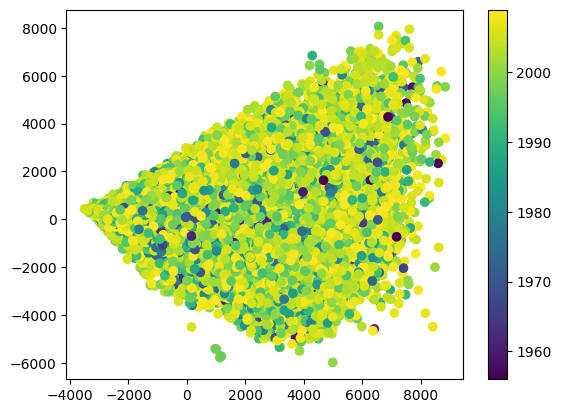

In [8]:
# VISUALIZZAZIONE IN 2 DIMENSIONI

X_cleaned = df_clean.drop(columns=['Year'])
y_cleaned = df_clean['Year']

pca = decomposition.PCA()
pca.fit(X_cleaned)

X_cleaned_p = pca.transform(X_cleaned)

plt.scatter(X_cleaned_p[:, 0], X_cleaned_p[:, 1], c=y_cleaned)
plt.colorbar()
plt.show()

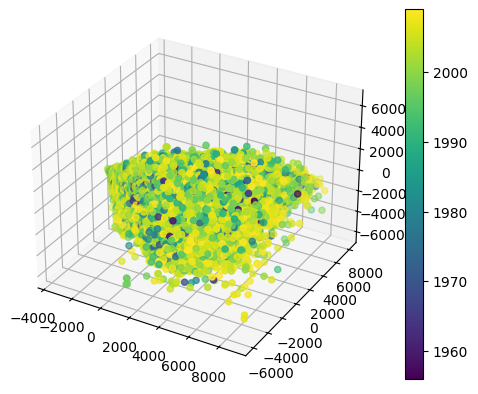

In [9]:
# VISUALIZZAZIONE IN 3 DIMENSIONI

X_cleaned = df_clean.drop(columns=['Year'])
y_cleaned = df_clean['Year']

pca = decomposition.PCA()
pca.fit(X_cleaned)
X_cleaned_p = pca.transform(X_cleaned)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_cleaned_p[:, 0], X_cleaned_p[:, 1], X_cleaned_p[:, 2], c=y_cleaned)
cbar = fig.colorbar(scatter, ax=ax)  

plt.show()

### Creo il dataset di train e quello di Validation (quest'ultimo verrà salvato nel Test Module)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('../Test_Module/test_data.csv', index=False)

### Carico il dataset di Train e Validation

In [2]:
df = pd.read_csv('train_data.csv')
X_train = df.drop(columns=['Year'])
y_train = df['Year']

df2 = pd.read_csv('../Test_Module/test_data.csv')
X_val = df.drop(columns=['Year'])
y_val = df['Year']

### Preprocessing dei dati

In [3]:
# MINMAX SCALER

# Applico il MinMaxScaling e salvo i valori
minmax_scaler = MinMaxScaler()
X_train_p = minmax_scaler.fit_transform(X_train)

with open("./models/minmax_scaler.save", "wb") as file:
    pickle.dump(minmax_scaler, file)

with open("../Test_Module/models/minmax_scaler.save", "wb") as file2:
    pickle.dump(minmax_scaler, file2)

In [3]:
# STANDARD SCALER

# Applico lo Standard Scaling e salvo i valori
std_scaler = StandardScaler()
X_train_p = std_scaler.fit_transform(X_train)

with open("./models/standardization.save", "wb") as file:
    pickle.dump(std_scaler, file)

with open("../Test_Module/models/standardization.save", "wb") as file2:
    pickle.dump(std_scaler, file2)

In [11]:
# NORMA L2

l2_normalizer = Normalizer(norm='l2')
X_train_p = l2_normalizer.transform(X_train)

with open("./models/normalizer_l2.save", "wb") as file:
    pickle.dump(l2_normalizer, file)

with open("../Test_Module/models/normalizer_l2.save", "wb") as file2:
    pickle.dump(l2_normalizer, file2)


C:\Users\racit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but Normalizer was fitted without feature names
  warnings.warn(


In [7]:
# PCA 30 parametri

pca30minmax = decomposition.PCA(n_components=30)
X_train_p = minmax_scaler.transform(X_train)
X_train_p = pca30minmax.fit_transform(X_train_p)

with open("./models/pca30minmax.save", "wb") as file:
    pickle.dump(pca30minmax, file)

with open("../Test_Module/models/pca30minmax.save", "wb") as file2:
    pickle.dump(pca30minmax, file2)

In [40]:
# PCA 70 parametri

pca70minmax = decomposition.PCA(n_components=70)
X_train_p = minmax_scaler.transform(X_train)
X_train_p = pca70minmax.fit_transform(X_train_p)

with open("./models/pca70minmax.save", "wb") as file:
    pickle.dump(pca70minmax, file)

with open("../Test_Module/models/pca70minmax.save", "wb") as file2:
    pickle.dump(pca70minmax, file2)

### Linear regression

In [25]:
# applico standardization
X_train_p = std_scaler.transform(X_train)

# applico normalizzazione l2
X_train_p = l2_normalizer.transform(X_train_p)

model = LinearRegression(fit_intercept=True).fit(X_train_p, y_train)

with open("./models/linearRegression.save", "wb") as file:
    pickle.dump(model, file)

with open("../Test_Module/models/linearRegression.save", "wb") as file2:
    pickle.dump(model, file2)

### Random Forest

In [49]:
# applico min-max Scaler
X_train_p = minmax_scaler.transform(X_train)

# applico pca 30 components
X_train_p = pca30minmax.transform(X_train_p)

model = RandomForestRegressor(n_estimators=500, min_samples_split=3,min_samples_leaf=8)
model.fit(X_train_p, y_train)

with open("./models/randomForest.save", "wb") as file:
    pickle.dump(model, file)


with open("../Test_Module/models/randomForest.save", "wb") as file2:
    pickle.dump(model, file2)

### KNN

In [47]:
# applico min-max Scaler
X_train_p = minmax_scaler.transform(X_train)

# applico pca 70 components 
X_train_p = pca70minmax.transform(X_train_p)



model = KNeighborsRegressor(n_neighbors=30, weights='distance', metric='euclidean')
model.fit(X_train_p, y_train)

with open("./models/knn.save", "wb") as file:
    pickle.dump(model, file)

with open("../Test_Module/models/knn.save", "wb") as file2:
    pickle.dump(model, file2)

### SVR

In [5]:
# applico min-max Scaler
X_train_p = minmax_scaler.transform(X_train)

model = SVR(C=10, gamma=10, kernel='rbf')
model.fit(X_train_p, y_train)

with open("./models/svr.save", "wb") as file:
    pickle.dump(model, file)

with open("../Test_Module/models/svr.save", "wb") as file2:
    pickle.dump(model, file2)

### Neural Network Feed-Forward

In [4]:
# Per riproducibilità

def fix_random(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True 

In [5]:
# Definisco il Data Layer

class MyDataset(Dataset):
    def __init__(self, X, y):
        
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
         
        self.num_features = X.shape[1]
        self.num_classes = 1                                   
       

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx]

In [6]:
# Definisco l'architettura del modello

class FeedForward(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FeedForward,self).__init__()

        model = [
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size//2),
            nn.BatchNorm1d(hidden_size//2),
            nn.ReLU(),
            nn.Linear(hidden_size//2, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU()
        ]

        
        self.model = nn.Sequential(*model)
        self.output = nn.Linear(hidden_size, num_classes)


    def forward(self, x):
        h = self.model(x)
        out = self.output(h)
        return out

In [7]:
# Definisco la funzione di test

def test_model(model, data_loader, device):
    model.eval()
    y_pred = []
    y_test = []
    
    for data, targets in data_loader:
        data, targets = data.to(device), targets.to(device).float()
        y_pred.append(model(data))
        y_test.append(targets)
    
    
    y_test = torch.stack(y_test).squeeze()
    y_pred = torch.stack(y_pred).squeeze()
    
    return y_test, y_pred

In [8]:
# Definisco la funzione di train

def train_model(model, criterion, optimizer, epoch, train_loader, val_loader, device):
    n_iter = 0
    best_valid_loss = float('inf')
    best_model = None
    for epoch in range(epoch):
        model.train()
        
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device).float()
            
            optimizer.zero_grad()

            # Forward pass
            y_pred = model(data)

            y_pred = y_pred.squeeze(1)

            # Calcolo Loss
            loss = criterion(y_pred, targets)

            # Backward pass
            loss.backward()
            optimizer.step()

            n_iter += 1

        # valido
        labels, y_pred = test_model(model, val_loader, device)
        loss_val = criterion(y_pred, labels)
        
        # salvo il modello migliore
        if loss_val.item() < best_valid_loss:
            best_valid_loss = loss_val.item()
            torch.save(model.state_dict(), './models/ff.pth')
            torch.save(model.state_dict(), '../Test_Module/models/ff.pth')

            
            
           
    return best_model

In [13]:
# look for GPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print("Device: {}".format(device))

Device: cpu


In [10]:
# Fisso il seed
seed = 42
fix_random(seed)

#### Preparazione dei dati e train

In [11]:
# applico min-max scaling
X_train_p = minmax_scaler.transform(X_train)
y_train_p = y_train.values

X_val_p = minmax_scaler.transform(X_val)
y_val_p = y_val.values


# genero i dataset
train_dataset = MyDataset(X_train_p,y_train_p)
val_dataset = MyDataset(X_val_p,y_val_p)


In [14]:
# iperparametri
hidden_size = 128
learning_rate = 0.01
num_epochs = 100
batch_size = 32

# genero i DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1)

# creo la rete neurale con i relativi parametri
model = FeedForward(train_dataset.num_features, hidden_size, train_dataset.num_classes)
model.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.999,0.999))

#train
model = train_model(model, criterion, optimizer, num_epochs, train_loader, val_loader, device)

### TabNet

In [4]:
# N.B.: QUESTO MODELLO E' STATO ADDESTRATO CON GPU. PER POTER ESEGUIRE QUESTO CODICE E AVERE GLI
# STESSI RISULTATI DEL MODELLO E' NECESSARIO INSTALLARE UNA VERSIONE DI TORCH CON CUDA COMPRESO
# (NON INSERITA NEI REQUIREMENTS A CAUSA DELLA NECESSITA' DI INSTALLARLO ESTERNAMENTE E DI VERSIONI 
# DIVERSE PER OGNI ARCHITETTURA).
# LA VERSIONE DA ME USATA E' "torch==2.1.2+cu118". NEI REQUIREMENTS.TXT HO INSERITO SOLO "torch==2.1.2"
# PER UTILIZZO GENERICO CON CPU. ADDESTRAMENTI AL MODELLO CON CPU INVECE DI GPU FORNIRANNO RISULTATI DIVERSI

# applico lo Standard Scaling
X_train_scaled = std_scaler.fit_transform(X_train)
X_val_scaled = std_scaler.transform(X_val)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)

# Concateno le feature e il target per creare il dataframe di train e val
train = pd.concat([X_train_scaled, y_train], axis=1)
val = pd.concat([X_val_scaled, y_val], axis=1)

feature_col_names = X_train.columns.tolist()
target_col_name = 'Year'

# Configuro i dati
data_config = DataConfig(
    target=[target_col_name],
    continuous_cols=feature_col_names,
    categorical_cols=[],
)

# Configuro il trainer
trainer_config = TrainerConfig(
    batch_size=32,
    max_epochs=25,
    early_stopping='valid_loss',
    early_stopping_patience=10,
)

# Configuro l'ottimizzatore
optimizer_config = OptimizerConfig()

# Configuro il modello TabNet
model_config = TabNetModelConfig(
    task="regression",
    n_d=8,
    n_a=8,
    n_steps=3,
    gamma=1.5,
    n_independent=3,
    n_shared=1,
    learning_rate=0.01
    # lambda_sparse=0.0001
)

# Creo  il modello mettendo insieme le configurazioni precedenti
tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)

# Addestro il modello
tabular_model.fit(train=train, validation=val)

# Salvo il modello e i pesi
os.makedirs('./models/tabnet', exist_ok=True)
tabular_model.save_model('./models/tabnet', inference_only=False)

os.makedirs('../Test_Module/models/tabnet', exist_ok=True)
tabular_model.save_model('../Test_Module/models/tabnet', inference_only=False)

tabular_model.save_weights('../Test_Module/models/tbweights.pth')
tabular_model.save_weights('./models/tbweights.pth')


2024-06-27 01:46:37,902 - {pytorch_tabular.tabular_model:140} - INFO - Experiment Tracking is turned off

Seed set to 42


2024-06-27 01:46:37,953 - {pytorch_tabular.tabular_model:524} - INFO - Preparing the DataLoaders

2024-06-27 01:46:38,035 - {pytorch_tabular.tabular_datamodule:499} - INFO - Setting up the datamodule for          
regression task

2024-06-27 01:46:41,884 - {pytorch_tabular.tabular_model:574} - INFO - Preparing the Model: TabNetModel

2024-06-27 01:46:41,904 - {pytorch_tabular.tabular_model:340} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


2024-06-27 01:46:43,585 - {pytorch_tabular.tabular_model:652} - INFO - Training Started

You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type           ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _embedding_layer │ Identity       │      0 │
│ 1 │ _backbone        │ TabNetBackbone │ 13.1 K │
│ 2 │ _head            │ Identity       │      0 │
│ 3 │ loss             │ MSELoss        │      0 │
└───┴──────────────────┴────────────────┴────────┘

Trainable params: 13.1 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 13.1 K                                                                                               
Total estimated model params size (MB): 0

Output()

C:\Users\racit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\
Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not 
have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to 
`num_workers=19` in the `DataLoader` to improve performance.

C:\Users\racit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\
Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not
have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to 
`num_workers=19` in the `DataLoader` to improve performance.

`Trainer.fit` stopped: `max_epochs=25` reached.


2024-06-27 06:13:25,593 - {pytorch_tabular.tabular_model:663} - INFO - Training the model completed

2024-06-27 06:13:25,593 - {pytorch_tabular.tabular_model:1489} - INFO - Loading the best model

2024-06-27 06:13:25,653 - {pytorch_tabular.tabular_model:1533} - WARNING - Directory is not empty. Overwriting the 
contents.

2024-06-27 06:13:26,437 - {pytorch_tabular.tabular_model:1533} - WARNING - Directory is not empty. Overwriting the 
contents.

In [5]:
# WORKAROUND PER FUNZIONAMENTO CON CPU!
# IL PARAMETRO "map_location='cpu'" USATO NEL TEST_MODULE PER SPOSTARE IL MODELLO SU CPU NON FUNZIONA CORRETTAMENTE!

# Configuro il trainer di nuovo (con 0 epoche di addestramento) ma con accelerator = 'cpu'
trainer_config2 = TrainerConfig(
    batch_size=32,
    max_epochs=0,
    early_stopping='valid_loss',
    early_stopping_patience=10,
    accelerator='cpu'
)

# Creo un nuovo modello con il nuovo trainer
tmp_tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config2,
)

# carico i pesi del modello vecchio addestrato su gpu e salvo il nuovo modello
tmp_tabular_model.fit(train=train, validation=val)
tmp_tabular_model.load_weights('./models/tbweights.pth')

tmp_tabular_model.save_model('./models/tabnet', inference_only=False)
tmp_tabular_model.save_model('../Test_Module/models/tabnet', inference_only=False)

2024-06-27 11:28:22,120 - {pytorch_tabular.tabular_model:140} - INFO - Experiment Tracking is turned off

Seed set to 42


2024-06-27 11:28:22,139 - {pytorch_tabular.tabular_model:524} - INFO - Preparing the DataLoaders

2024-06-27 11:28:22,352 - {pytorch_tabular.tabular_datamodule:499} - INFO - Setting up the datamodule for          
regression task

2024-06-27 11:28:26,103 - {pytorch_tabular.tabular_model:574} - INFO - Preparing the Model: TabNetModel

2024-06-27 11:28:26,136 - {pytorch_tabular.tabular_model:340} - INFO - Preparing the Trainer

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\racit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\trainer\setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


2024-06-27 11:28:26,185 - {pytorch_tabular.tabular_model:652} - INFO - Training Started

C:\Users\racit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:639: Checkpoint directory C:\Users\racit\CONSEGNA - esame data analytics\Train_Module\saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type           ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _embedding_layer │ Identity       │      0 │
│ 1 │ _backbone        │ TabNetBackbone │ 13.1 K │
│ 2 │ _head            │ Identity       │      0 │
│ 3 │ loss             │ MSELoss        │      0 │
└───┴──────────────────┴────────────────┴────────┘

Trainable params: 13.1 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 13.1 K                                                                                               
Total estimated model params size (MB): 0

Output()

C:\Users\racit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\
Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not 
have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to 
`num_workers=19` in the `DataLoader` to improve performance.

C:\Users\racit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\
Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not
have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to 
`num_workers=19` in the `DataLoader` to improve performance.

`Trainer.fit` stopped: `max_epochs=0` reached.


2024-06-27 11:28:26,638 - {pytorch_tabular.tabular_model:663} - INFO - Training the model completed

2024-06-27 11:28:26,641 - {pytorch_tabular.tabular_model:1489} - INFO - Loading the best model

2024-06-27 11:28:26,642 - {pytorch_tabular.tabular_model:1497} - WARNING - No best model available to load. Did you
run it more than 1 epoch?...

2024-06-27 11:28:26,663 - {pytorch_tabular.tabular_model:1533} - WARNING - Directory is not empty. Overwriting the 
contents.

2024-06-27 11:28:26,998 - {pytorch_tabular.tabular_model:1533} - WARNING - Directory is not empty. Overwriting the 
contents.

### TabTransformer

In [4]:
# N.B.: QUESTO MODELLO E' STATO ADDESTRATO CON GPU. PER POTER ESEGUIRE QUESTO CODICE E AVERE GLI
# STESSI RISULTATI DEL MODELLO E' NECESSARIO INSTALLARE UNA VERSIONE DI TORCH CON CUDA COMPRESO
# (NON INSERITA NEI REQUIREMENTS A CAUSA DELLA NECESSITA' DI INSTALLARLO ESTERNAMENTE E DI VERSIONI 
# DIVERSE PER OGNI ARCHITETTURA).
# LA VERSIONE DA ME USATA E' "torch==2.1.2+cu118". NEI REQUIREMENTS.TXT HO INSERITO SOLO "torch==2.1.2"
# PER UTILIZZO GENERICO CON CPU. ADDESTRAMENTI AL MODELLO CON CPU INVECE DI GPU FORNIRANNO RISULTATI DIVERSI

# applico lo Standard Scaling
X_train_scaled = std_scaler.fit_transform(X_train)
X_val_scaled = std_scaler.transform(X_val)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)

# Concateno le feature e il target per creare il dataframe di train e val
train = pd.concat([X_train_scaled, y_train], axis=1)
val = pd.concat([X_val_scaled, y_val], axis=1)

feature_col_names = X_train.columns.tolist()
target_col_name = 'Year'

# Configuro i dati
data_config = DataConfig(
    target=[target_col_name],
    continuous_cols=feature_col_names,
    categorical_cols=[],
)

# Configuro il trainer
trainer_config = TrainerConfig(
    batch_size=2048,
    max_epochs=100,
    early_stopping='valid_loss',
    early_stopping_patience=10,
)

# Configuro l'ottimizzatore
optimizer_config = OptimizerConfig()

# Configuro il modello TabTransformer
model_config = TabTransformerConfig(
    task="regression",
    num_heads=2,
    num_attn_blocks= 11,
    ff_hidden_multiplier = 6,
    batch_norm_continuous_input = True,
    learning_rate=0.001,
    transformer_head_dim = 64,
    # transformer_activation = 'ReGLU'
)

# Creo  il modello mettendo insieme le configurazioni precedenti
tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)

# Addestro il modello
tabular_model.fit(train=train, validation=val)

# Salvo il modello e i pesi
os.makedirs('./models/tabtransformer', exist_ok=True)
tabular_model.save_model('./models/tabtransformer', inference_only=False)

os.makedirs('../Test_Module/models/tabtransformer', exist_ok=True)
tabular_model.save_model('../Test_Module/models/tabtransformer', inference_only=False)

tabular_model.save_weights('../Test_Module/models/tfweights.pth')
tabular_model.save_weights('./models/tfweights.pth')


2024-07-01 10:37:35,719 - {pytorch_tabular.tabular_model:140} - INFO - Experiment Tracking is turned off

Seed set to 42


2024-07-01 10:37:35,885 - {pytorch_tabular.tabular_model:524} - INFO - Preparing the DataLoaders

2024-07-01 10:37:36,074 - {pytorch_tabular.tabular_datamodule:499} - INFO - Setting up the datamodule for          
regression task

2024-07-01 10:37:45,290 - {pytorch_tabular.tabular_model:574} - INFO - Preparing the Model: TabTransformerModel

2024-07-01 10:37:45,339 - {pytorch_tabular.tabular_model:340} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


2024-07-01 10:37:46,705 - {pytorch_tabular.tabular_model:652} - INFO - Training Started

You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: c:\Users\racit\CONSEGNA - esame data analytics\Train_Module\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                   ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ TabTransformerBackbone │  294 K │
│ 1 │ _embedding_layer │ Embedding2dLayer       │      0 │
│ 2 │ _head            │ LinearHead             │     91 │
│ 3 │ loss             │ MSELoss                │      0 │
└───┴──────────────────┴────────────────────────┴────────┘

Trainable params: 294 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 294 K                                                                                                
Total estimated model params size (MB): 1

Output()

C:\Users\racit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\
Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not 
have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to 
`num_workers=19` in the `DataLoader` to improve performance.

C:\Users\racit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\
Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not
have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to 
`num_workers=19` in the `DataLoader` to improve performance.

2024-07-01 11:09:41,659 - {pytorch_tabular.tabular_model:663} - INFO - Training the model completed

2024-07-01 11:09:41,665 - {pytorch_tabular.tabular_model:1489} - INFO - Loading the best model

In [5]:
# WORKAROUND PER FUNZIONAMENTO CON CPU!
# IL PARAMETRO "map_location='cpu'" USATO NEL TEST_MODULE PER SPOSTARE IL MODELLO SU CPU NON FUNZIONA CORRETTAMENTE!

# Configuro il trainer di nuovo (con 0 epoche di addestramento) ma con accelerator = 'cpu'
trainer_config2 = TrainerConfig(
    batch_size=2048,
    max_epochs=0,
    early_stopping='valid_loss',
    early_stopping_patience=10,
    accelerator='cpu'
)

# Creo un nuovo modello con il nuovo trainer
tmp_tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config2,
)

# carico i pesi del modello vecchio addestrato su gpu e salvo il nuovo modello
tmp_tabular_model.fit(train=train, validation=val)
tmp_tabular_model.load_weights('./models/tfweights.pth')

tmp_tabular_model.save_model('./models/tabtransformer', inference_only=False)
tmp_tabular_model.save_model('../Test_Module/models/tabtransformer', inference_only=False)

2024-07-01 11:23:23,200 - {pytorch_tabular.tabular_model:140} - INFO - Experiment Tracking is turned off

Seed set to 42


2024-07-01 11:23:23,249 - {pytorch_tabular.tabular_model:524} - INFO - Preparing the DataLoaders

2024-07-01 11:23:23,616 - {pytorch_tabular.tabular_datamodule:499} - INFO - Setting up the datamodule for          
regression task

2024-07-01 11:23:31,111 - {pytorch_tabular.tabular_model:574} - INFO - Preparing the Model: TabTransformerModel

2024-07-01 11:23:31,162 - {pytorch_tabular.tabular_model:340} - INFO - Preparing the Trainer

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\racit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\trainer\setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


2024-07-01 11:23:31,237 - {pytorch_tabular.tabular_model:652} - INFO - Training Started

C:\Users\racit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:639: Checkpoint directory C:\Users\racit\CONSEGNA - esame data analytics\Train_Module\saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                   ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ TabTransformerBackbone │  294 K │
│ 1 │ _embedding_layer │ Embedding2dLayer       │      0 │
│ 2 │ _head            │ LinearHead             │     91 │
│ 3 │ loss             │ MSELoss                │      0 │
└───┴──────────────────┴────────────────────────┴────────┘

Trainable params: 294 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 294 K                                                                                                
Total estimated model params size (MB): 1

Output()

C:\Users\racit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\
Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not 
have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to 
`num_workers=19` in the `DataLoader` to improve performance.

C:\Users\racit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\
Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not
have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to 
`num_workers=19` in the `DataLoader` to improve performance.

`Trainer.fit` stopped: `max_epochs=0` reached.


2024-07-01 11:23:31,616 - {pytorch_tabular.tabular_model:663} - INFO - Training the model completed

2024-07-01 11:23:31,630 - {pytorch_tabular.tabular_model:1489} - INFO - Loading the best model

2024-07-01 11:23:31,631 - {pytorch_tabular.tabular_model:1497} - WARNING - No best model available to load. Did you
run it more than 1 epoch?...

2024-07-01 11:23:31,685 - {pytorch_tabular.tabular_model:1533} - WARNING - Directory is not empty. Overwriting the 
contents.

2024-07-01 11:23:32,448 - {pytorch_tabular.tabular_model:1533} - WARNING - Directory is not empty. Overwriting the 
contents.